# Analysis on Kickstarter

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
# Show all columns
pd.set_option('display.max_columns', None)


In [2]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328653, 134)

# Visualize the Data

Text(0.5, 1.0, 'New Kickstarter Creators by Year')

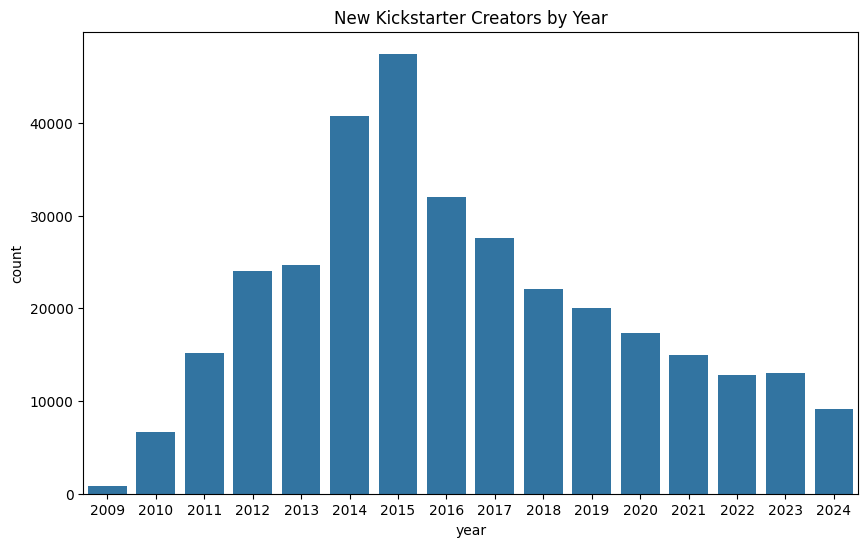

In [3]:
# New Kickstarter Creators by Year
df['year'] = df['launched_at'].dt.year
df['month'] = df['launched_at'].dt.month

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='year')
plt.title('New Kickstarter Creators by Year')

Check first project statistics

In [4]:
# Convert some key statistics to integers
df['spotlight'] = df['spotlight'].astype(int)

# Replace missing with zeros for prelaunch_activated
df['prelaunch_activated'] = df['prelaunch_activated'].fillna(0)

In [5]:
print(df[['goal', 'pledged', 'staff_pick', 'backers_count', 'spotlight', 'prelaunch_activated']].describe().apply(lambda s: s.apply('{0:.2f}'.format)))

                goal       pledged staff_pick backers_count  spotlight  \
count      328653.00     328653.00  321020.00     328653.00  328653.00   
mean        55322.02      30048.42       0.11        129.73       0.50   
std       2102742.08    1318562.73       0.32        942.75       0.50   
min             1.00          0.00       0.00          0.00       0.00   
25%          2000.00         75.00       0.00          3.00       0.00   
50%          5000.00       1260.00       0.00         21.00       0.00   
75%         15000.00       6383.01       0.00         77.00       1.00   
max    1000000000.00  481621841.00       1.00     219382.00       1.00   

      prelaunch_activated  
count           328653.00  
mean                 0.08  
std                  0.28  
min                  0.00  
25%                  0.00  
50%                  0.00  
75%                  0.00  
max                  1.00  


Define the Discontinuity

In [6]:
# Create Discontinuity Columns
df['percent_to_goal'] = df['pledged'] / df['goal']
df['dollars_to_goal'] = df['goal'] - df['pledged']

Plot the density near the discontinuity

<Axes: xlabel='percent_to_goal', ylabel='Count'>

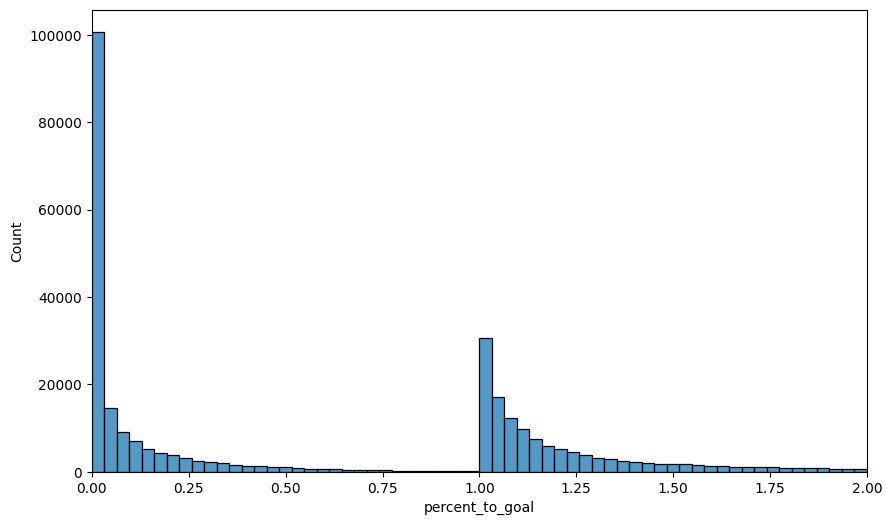

In [18]:
# Plot percent to goal on x axis and total number of projects on y axis
plotting_df = df.copy()
plotting_df = plotting_df[plotting_df['percent_to_goal'] < 2]

plt.figure(figsize=(10,6))
plt.xlim(0, 2)
sns.histplot(data=plotting_df, x='percent_to_goal')

<Axes: xlabel='percent_to_goal', ylabel='total_canceled_after_first'>

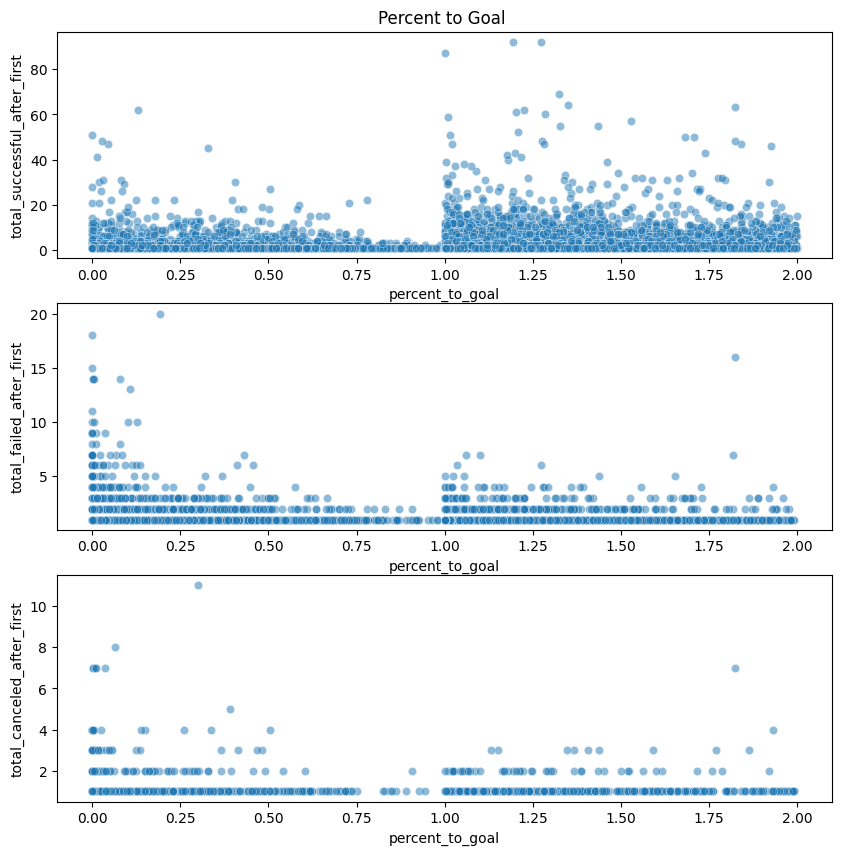

In [20]:
plt.figure(figsize=(10,10))
ax = plt.subplot(3, 1, 1)

sns.scatterplot(data=plotting_df, x = 'percent_to_goal', y = 'total_successful_after_first', alpha = 0.5, ax = ax)
plt.title('Percent to Goal ')

ax = plt.subplot(3, 1, 2, sharex = ax)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_failed_after_first', alpha = 0.5, ax = ax)

ax = plt.subplot(3, 1, 3, sharex = ax)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_canceled_after_first', alpha = 0.5, ax = ax)

In [9]:
# Filter out people too high or too low
modified_df = df.copy()
modified_df = modified_df[(modified_df['percent_to_goal'] <= 2) & (modified_df['percent_to_goal'] > -2)]
# Keep binned data
modified_df['percent_to_goal_binned'] = pd.cut(modified_df['percent_to_goal'], bins=20)
binned_data = modified_df.groupby('percent_to_goal_binned').agg({'total_successful_after_first': 'mean', 'total_failed_after_first': 'mean'}).reset_index()
binned_data['percent_to_goal'] = binned_data['percent_to_goal_binned'].apply(lambda interval: interval.mid)  # Get the midpoint of each bin



C:\Users\d0tam\AppData\Local\Temp\ipykernel_20140\504103981.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = modified_df.groupby('percent_to_goal_binned').agg({'total_successful_after_first': 'mean', 'total_failed_after_first': 'mean'}).reset_index()


Average Successfull Campaigns After First

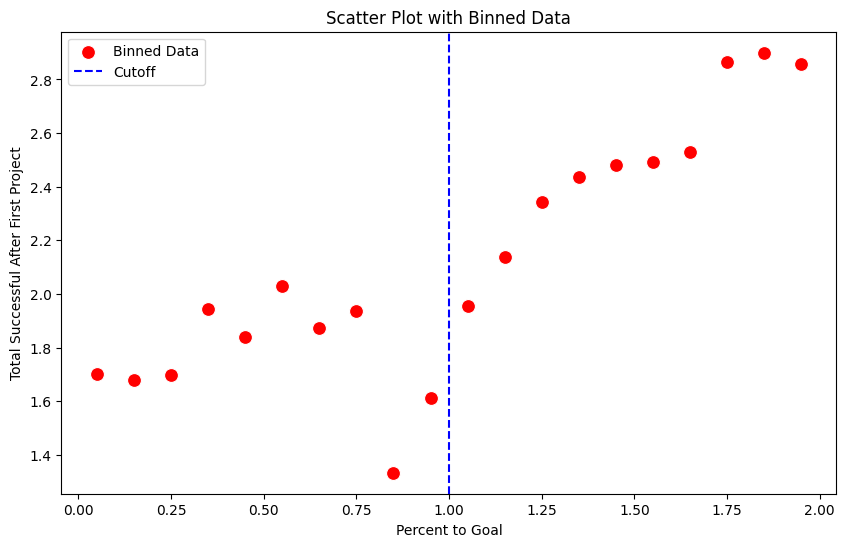

In [10]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=binned_data, x='percent_to_goal', y='total_successful_after_first', color='red', label='Binned Data', s=100)

plt.xlabel('Percent to Goal')
plt.ylabel('Total Successful After First Project')
plt.axvline(x=1, color='blue', linestyle='--', label='Cutoff')
plt.legend()
plt.title('Scatter Plot with Binned Data')
plt.show()

Average Failed Campaigns After First

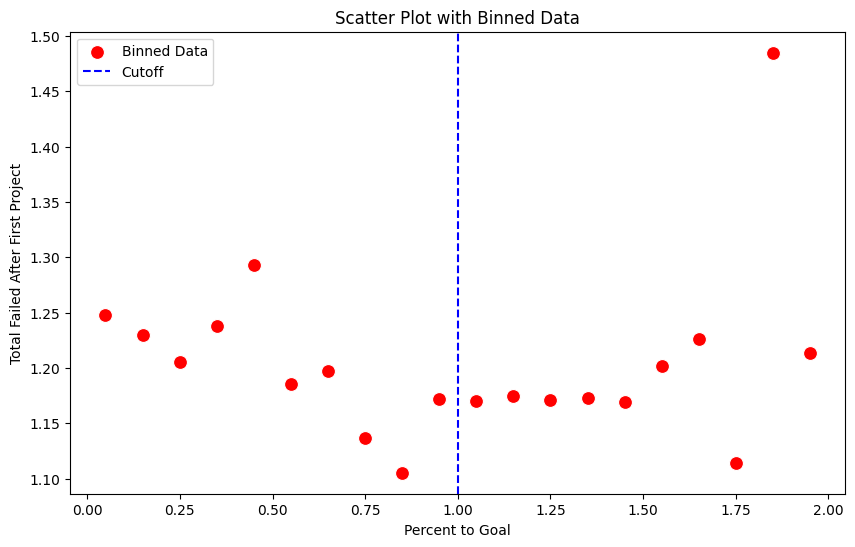

In [11]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=binned_data, x='percent_to_goal', y='total_failed_after_first', color='red', label='Binned Data', s=100)

plt.xlabel('Percent to Goal')
plt.ylabel('Total Failed After First Project')
plt.axvline(x=1, color='blue', linestyle='--', label='Cutoff')
plt.legend()
plt.title('Scatter Plot with Binned Data')
plt.show()

# Discontinuity Analysis

In [54]:
rdd_df = df.assign(threshold = (df['percent_to_goal'] > 1).astype(int)).sort_values('percent_to_goal')

Naive Model

In [56]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7093,0.068,25.081,0.000,1.576,1.843
percent_to_goal,0.1570,0.187,0.840,0.401,-0.209,0.523
threshold,0.9046,0.072,12.557,0.000,0.763,1.046
percent_to_goal:threshold,-0.1561,0.187,-0.836,0.403,-0.522,0.210


Text(0.5, 1.0, 'Regression Discontinuity')

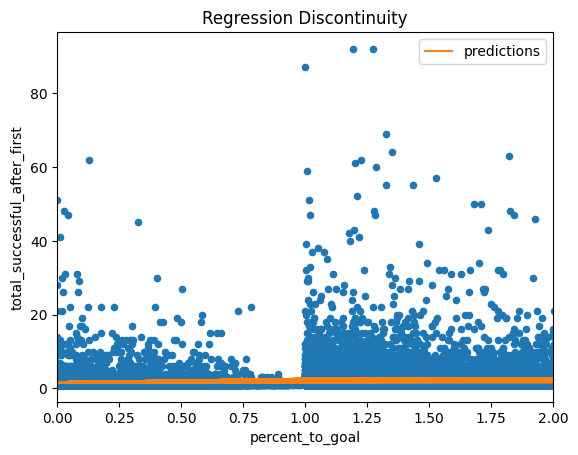

In [58]:
ax = rdd_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")
df.assign(predictions = model.fittedvalues).plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
plt.xlim(0, 2)
plt.title('Regression Discontinuity')

Kernel weighted RD

In [23]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(float)
    return indicator * (1 - np.abs(R - c) / h)

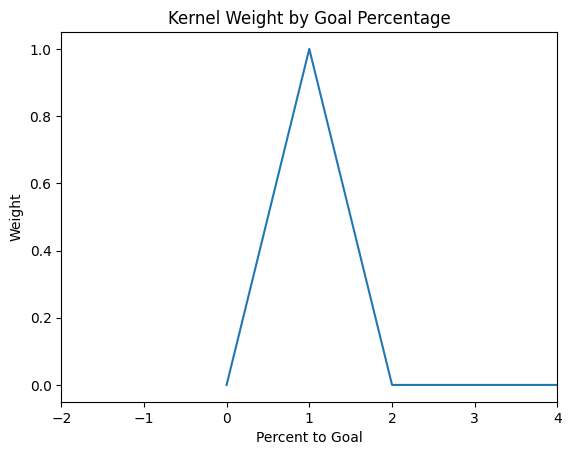

In [59]:
plt.plot(sorted(rdd_df["percent_to_goal"]), kernel(rdd_df["percent_to_goal"], c=1, h=1))
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-2, 4)
plt.title("Kernel Weight by Goal Percentage");

In [60]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()

model.summary().tables[1]

c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8638,0.111,16.835,0.000,1.647,2.081
percent_to_goal,-0.1386,0.184,-0.752,0.452,-0.500,0.223
threshold,-1.1222,0.172,-6.516,0.000,-1.460,-0.785
percent_to_goal:threshold,1.3393,0.214,6.246,0.000,0.919,1.760


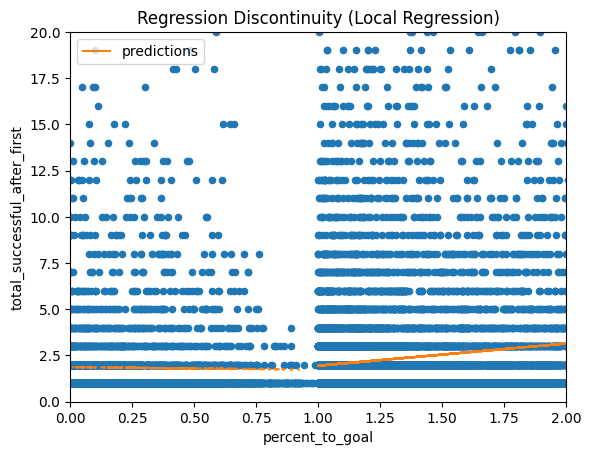

In [61]:
ax = rdd_df.plot.scatter(x="percent_to_goal", y="total_successful_after_first", color="C0")
rdd_df.assign(predictions=model.fittedvalues).plot(x="percent_to_goal", y="predictions", ax=ax, color="C1")
plt.xlim(0, 2)
plt.ylim(0, 20)
plt.title("Regression Discontinuity (Local Regression)");

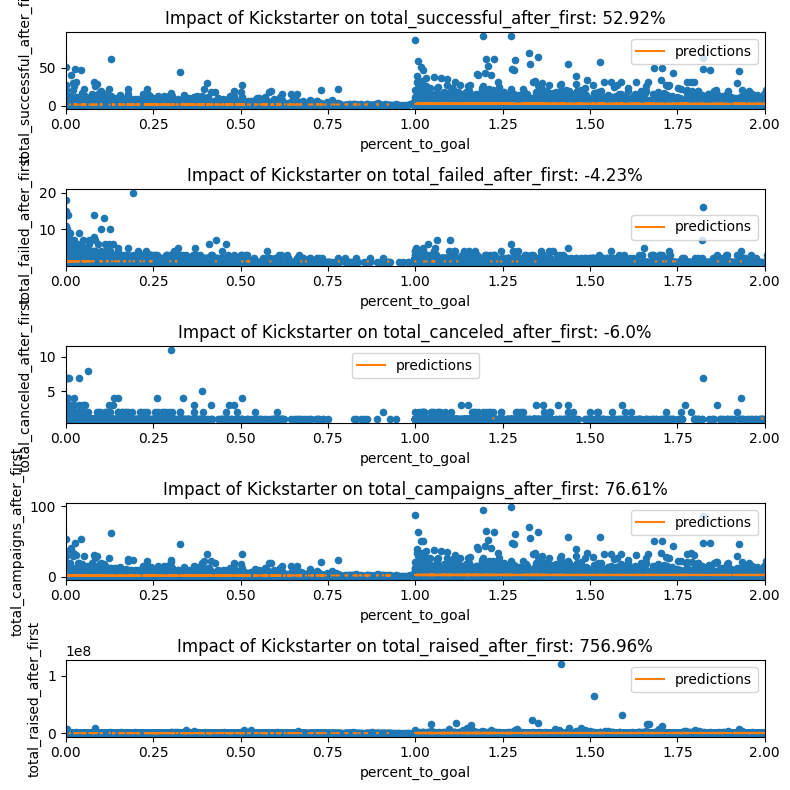

In [65]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["total_successful_after_first", "total_failed_after_first", "total_canceled_after_first", "total_campaigns_after_first", "total_raised_after_first"], 1):
    ax = plt.subplot(5,1,p)
    rdd_df.plot.scatter(x="percent_to_goal", y=cause, ax=ax)
    plt.xlim(0, 2)
    
    m = smf.wls(f"{cause}~percent_to_goal*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    rdd_df.assign(predictions=m.fittedvalues).plot(x="percent_to_goal", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Kickstarter on {cause}: {np.round(ate_pct, 2)}%")

plt.tight_layout()

# McCrary Test

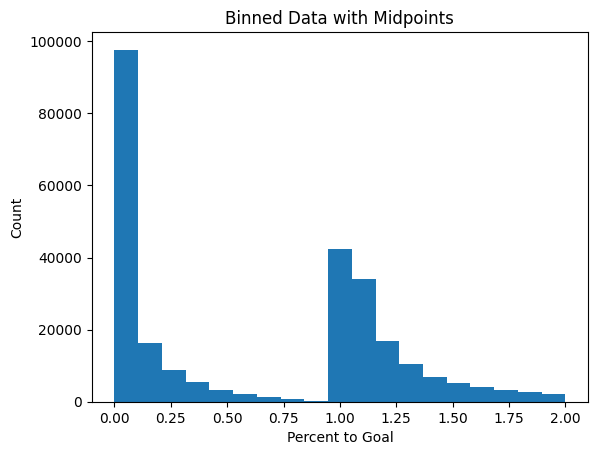

In [76]:
bins = np.linspace(0, 2, 20)

rdd_df['bin'] = pd.cut(rdd_df['percent_to_goal'], bins)

# Get Bin Counts
bin_counts = rdd_df['bin'].value_counts(sort = False)

# Calculate the midpoints for each bin
midpoints = bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Plot the bar plot
plt.bar(midpoints, bin_counts, width=(bins[1] - bins[0]), align='center')
plt.xlabel('Percent to Goal')
plt.ylabel('Count')
plt.title('Binned Data with Midpoints')
plt.show()
